In [1]:
import pandas as pd

import os
import pickle as pkl

from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, KFold, cross_val_predict
from sklearn.metrics import r2_score, explained_variance_score, normalized_mutual_info_score, \
    mutual_info_score, mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

from skll.metrics import spearman, pearson 


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns

from IPython.display import SVG,display,set_matplotlib_formats
set_matplotlib_formats('svg')

from PIL import Image

import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 5,5

Custom model implementations and functions are stored in `src/dairyml.py`

In [2]:
from dairyml import PerfectClassifierMeanRegressor, plot_r2, BoundedLasso, BoundedLassoPlusLogReg, plot_coefficients, DummyRegressorCustom

## Import the Data
Load the data from the csv file, and set FoodCode to be the data index

In [3]:
data = pd.read_csv('../data/training_for_GS_122118.csv')
data = data.set_index('FoodCode')

Get the indices of all columns except description and lactose content - these columns are the numerical features that will be used as model input



In [4]:
numerical_features = [col for col in data.columns if col not in ['Food_Description','lac.per.100g']]
# print(numerical_features)

## Assess correlation of features with target variable

### Spearman's rank correlation coefficient

In [5]:
correlations = pd.DataFrame()
correlations['SRC'] = data[list(numerical_features) + ['lac.per.100g']].corr(method='spearman')['lac.per.100g']

### Mutual Information

In [6]:
for col in numerical_features:
    correlations.loc[col,'MI'] = mutual_info_score(data[col],data['lac.per.100g'])
    correlations.loc[col,'NMI'] = normalized_mutual_info_score(data[col],data['lac.per.100g'])

### Report average values for each correlation measure

In [7]:
correlations.abs().mean(axis=0)

SRC    0.204037
MI     3.192658
NMI    0.726827
dtype: float64

In [8]:
# correlations.to_excel('../data/correlations.xlsx')

## Prepare data for modelling
### Standardize the input features
- Use only the numerical features as model input `X`  
- Use sklearn's `StandardScaler` on these features: this standardizes features by removing the mean and scaling to unit variance 
- Convert the output of `StandardScaler` back to a dataframe for convenience

In [9]:
ss = StandardScaler()
ss.fit(data[numerical_features])
X = (data[numerical_features] - ss.mean_) / np.sqrt(ss.var_) #done by hand rather than fit_transform just to use same syntax as test script

In [10]:
X

,KCAL,PROT,TFAT,CARB,MOIS,ALC,CAFF,SUGR,FIBE,CALC,...,P182,P183,P184,P204,P205,P225,P226,VITD,CHOLN,year
FoodCode,,,,,,,,,,,,,,,,,,,,,
11220000,0.702498,-0.107073,-0.255593,2.029871,-1.272677,-0.081228,-0.106147,3.315742,-0.733664,0.479038,...,-0.340521,-0.213564,-0.235027,-0.425155,-0.273708,-0.344888,-0.282114,-0.218465,1.701262,-1.226096
11516000,-1.178711,-0.622714,-0.817326,-0.712226,1.230875,-0.081228,-0.106147,-0.222954,-0.610571,-0.179715,...,-0.377025,-0.604177,-0.235027,-0.425155,-0.273708,-0.344888,-0.282114,0.834216,-0.233236,-1.226096
11531000,-0.908979,-0.512824,-0.585036,-0.621834,1.005822,-0.081228,-0.106147,-0.041202,-0.733664,-0.201821,...,-0.357096,-0.420557,-0.235027,-0.321806,-0.273708,-0.344888,-0.282114,0.834216,0.669716,-1.226096
11830800,0.951482,1.340827,-0.788838,2.704954,-2.085663,-0.081228,0.321872,4.147861,-0.487477,0.483459,...,-0.334404,-0.514036,-0.235027,-0.425155,-0.273708,-0.344888,-0.282114,-0.429001,3.359004,-1.226096
13210250,-0.943560,-0.730190,-0.807100,-0.190467,0.881982,-0.081228,-0.071905,0.095295,-0.487477,-0.330035,...,-0.376039,-0.570791,-0.235027,-0.425155,-0.273708,-0.344888,-0.282114,0.202608,-0.484833,-1.226096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12210400,2.251730,-0.483841,1.700613,2.057332,-2.299195,-0.081228,-0.106147,3.350778,-0.733664,-0.679307,...,-0.382551,-0.584140,-0.235027,-0.425155,-0.273708,-0.344888,-0.282114,-0.429001,-0.725247,0.815597
54401020,2.064992,-0.334100,1.184169,2.522453,-2.376544,-0.081228,-0.106147,-0.570401,2.528318,-0.051501,...,2.337715,0.120284,-0.235027,-0.425155,-0.273708,-0.344888,-0.282114,-0.429001,-0.451287,-1.226096
42401010,0.073123,-0.785739,0.850343,-0.765432,0.391969,-0.081228,-0.106147,-0.411276,0.620366,-0.705834,...,-0.331642,-0.617530,-0.235027,-0.425155,-0.273708,-0.344888,-0.282114,-0.429001,-0.551925,-1.226096


Save mean and variance to file for use in test script

In [11]:
np.savetxt('../scaling/train_feature_means.csv',ss.mean_,delimiter=',')
np.savetxt('../scaling/train_feature_variances.csv',ss.var_,delimiter=',')

### Remove outliers

`contamination` parameter was hand-tuned based on the appearance of PCA & t-SNE visualizations below, increasing until data points that appeared to be outliers were removed

In [12]:
iso = IsolationForest(contamination=.013,random_state=7)
outliers = iso.fit_predict(X)
print('Outliers removed: {}'.format(sum(outliers == -1)))

Outliers removed: 5


### Use lactose as prediction target `Y`

In [13]:
Y = data['lac.per.100g']

In [14]:
X_in = X[outliers == 1]
Y_in = Y[outliers == 1]

## Distribution of target variable, class imbalance

In [15]:
Y_binary = (Y_in != 0).replace(True,'lactose').replace(False,'non-lactose')

#### Class absolute numbers

In [16]:
Y_binary.value_counts()

lactose        287
non-lactose     86
Name: lac.per.100g, dtype: int64

#### Class proportions

In [17]:
Y_binary.value_counts().divide(Y_binary.value_counts().sum()).round(2)

lactose        0.77
non-lactose    0.23
Name: lac.per.100g, dtype: float64

#### Distribution of all lactose values

In [18]:
ax = sns.distplot(Y_in,bins=20)
_ = ax.set_title("Distribution of all lactose values")
ax.figure.savefig('../graphics/lactose_distribution_all.png')

reload and save as tiff

In [19]:
img = Image.open(open('../graphics/lactose_distribution_all.png','rb'))
img.save('../graphics/lactose_distribution_all.tiff',dpi=(300,300))

#### Distribution of nonzero lactose values

In [20]:
ax = sns.distplot(Y_in[Y_in!=0],bins=20)
_ = ax.set_title("Distribution of nonzero lactose values")
ax.figure.savefig('../graphics/lactose_distribution_nonzero.png')

reload and save as tiff

In [21]:
img = Image.open(open('../graphics/lactose_distribution_nonzero.png','rb'))
img.save('../graphics/lactose_distribution_nonzero.tiff',dpi=(300,300))

## Visualization: PCA & t-SNE

Create axes to plot visualization results

In [22]:
f, axes = plt.subplots(2, 2, figsize=(10,5))

Create a colormap to outline the outliers

In [23]:
red = np.array([212/256, 17/256, 17/256, 1])
nocolor = np.array([1,1,1,0])
colors = np.array([red,nocolor])

newcmp = ListedColormap(colors)

In [24]:
newcmp

### PCA

Here we use PCA to visualize the features along two axes. Two plots are produced. In the first, the data points are colored by lactose value. In the second, the data points are colored by the logarithm of the lactose values. Since most lactose values are low, with a few high exceptions, coloring by lactose value directly obscures the differences on the lower end of the distribution, so coloring by log lactose attempts to fix that.  

In [25]:
pca = PCA(n_components=2)
pca.fit(X_in)
pca_results = pd.DataFrame(pca.transform(X),columns=['PC1','PC2'],index=X.index)
pca_results['outlier_status'] = outliers

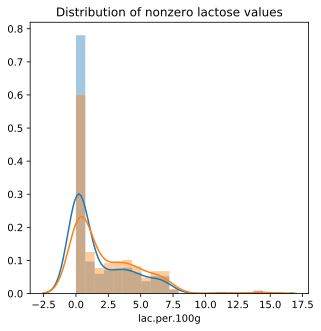

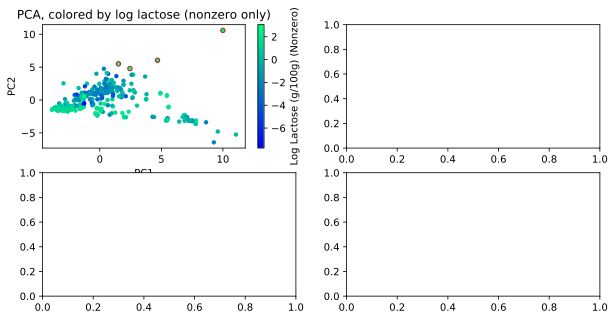

Text(0.5, 1, 'PCA, colored by log lactose')

In [26]:
pca_results['lac.per.100g'] = Y
pca_results['log.lac.per.100g'] = np.log(pca_results['lac.per.100g'] + .001)
pca_results['log_nonzero.lac.per.100g'] = np.log(pca_results['lac.per.100g'])
pca_results = pca_results.rename(columns={'lac.per.100g':'Lactose (g/100g)',
                             'log.lac.per.100g':'Log Lactose (g/100g)',
                             'log_nonzero.lac.per.100g':'Log Lactose (g/100g) (Nonzero)'})
# cmap = cm.get_cmap('Spectral')
ax = pca_results.plot.scatter('PC1','PC2',c='Log Lactose (g/100g) (Nonzero)',colormap='winter',ax=axes[0,0], edgecolors=newcmp(outliers))
axes[0,0].set_xlabel('PC1')
axes[0,0].set_title('PCA, colored by log lactose (nonzero only)')
plt.show()
ax = pca_results.plot.scatter('PC1','PC2',c='Log Lactose (g/100g)',colormap='winter',ax=axes[0,1], edgecolors=newcmp(outliers))
axes[0,1].set_xlabel('PC1')
axes[0,1].set_title('PCA, colored by log lactose')

### t-SNE

The same plots are created using t-SNE, a different visualization technique.

In [27]:
tsne = TSNE(n_components=2,perplexity=30,random_state=7)
tsne_results = pd.DataFrame(tsne.fit_transform(X),columns=['axis 1','axis 2'],index=X.index)
tsne_results['outlier_status'] = outliers

In [28]:
tsne_results['lac.per.100g'] = Y
tsne_results['log.lac.per.100g'] = np.log(tsne_results['lac.per.100g'] + .001)
tsne_results['log_nonzero.lac.per.100g'] = np.log(tsne_results['lac.per.100g'])
tsne_results = tsne_results.rename(columns={'lac.per.100g':'Lactose (g/100g)',
                             'log.lac.per.100g':'Log Lactose (g/100g)',
                             'log_nonzero.lac.per.100g':'Log Lactose (g/100g) (Nonzero)'})

ax = tsne_results.plot.scatter('axis 1','axis 2',c='Log Lactose (g/100g) (Nonzero)',colormap='winter',ax=axes[1,0], edgecolors=newcmp(outliers))
axes[1,0].set_xlabel('axis 1')
axes[1,0].set_title('t-SNE, colored by log lactose (nonzero only)')

ax = tsne_results.plot.scatter('axis 1','axis 2',c='Log Lactose (g/100g)',colormap='winter',ax=axes[1,1], edgecolors=newcmp(outliers))
axes[1,1].set_xlabel('axis 1')
axes[1,1].set_title('t-SNE, colored by log lactose')

Text(0.5, 1, 't-SNE, colored by log lactose')

In [29]:
f.tight_layout()

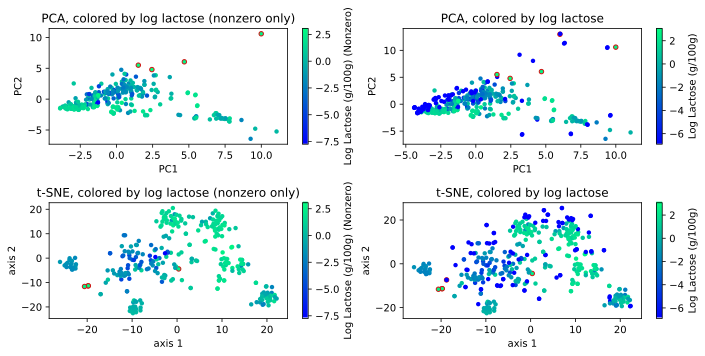

In [30]:
f

In [31]:
f.savefig('../graphics/pca_tsne_plots.png')

reload and save as tiff

In [32]:
img = Image.open(open('../graphics/pca_tsne_plots.png','rb'))
img.save('../graphics/pca_tsne_plots.tiff',dpi=(300,300))

Export pca and tsne results to file

In [33]:
pca_results.to_csv('../graphics/pca_results.csv')

In [34]:
tsne_results.to_csv('../graphics/tsne_results.csv')

### Save preprocessed data to pickle files

In [35]:
data_to_save = [X_in, Y_in]
data_dir = '../pkl/data/'
try:
    os.makedirs(data_dir)
except FileExistsError:
    pass

save_string = "data_outliers_removed"

with open(data_dir + save_string, "wb" ) as f:
    pkl.dump(data_to_save,f)

print('saved to {}'.format(data_dir + save_string))

saved to ../pkl/data/data_outliers_removed
